In [1]:
from flask import Flask, request, make_response
from flask_restx import Resource, Api, reqparse
from flask_cors import CORS
import pymysql
import pandas as pd
import json
import boto3
from datetime import datetime
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
from pydub.silence import split_on_silence

import io
import collections
import contextlib
import sys
import wave
import webrtcvad
import os
import ssl
import werkzeug
from werkzeug.utils import secure_filename
import numpy as np
from datetime import datetime


import datetime, json
import requests
from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.ai.anomalydetector.models import DetectRequest, TimeSeriesPoint, TimeGranularity, \
    AnomalyDetectorError
from azure.core.credentials import AzureKeyCredential
import pandas as pd
from dateutil import parser
from pymongo import MongoClient

import time
import anomaly
import matplotlib.pyplot as plt

In [ ]:
app = Flask(__name__)
app.config['JSON_AS_ASCII'] = False
api = Api(app)

CORS(app, resources={r'/*': {'origins': '*'}})
SUBSCRIPTION_KEY = '20fb2829f07c4018938ce3a45fc0bcd1'
ANOMALY_DETECTOR_ENDPOINT = 'https://v-dat.cognitiveservices.azure.com/anomalydetector/v1.1-preview/timeseries/entire/detect'

@api.route('/hello')  # 데코레이터 이용, '/hello' 경로에 클래스 등록
class HelloWorld(Resource):
    def get(self):  # GET 요청시 리턴 값에 해당 하는 dict를 JSON 형태로 반환
        print(request.json)
        return {"This is": "Test!"}
    
@api.route('/upload')
class Upload(Resource):
    def post(self):
        parser = reqparse.RequestParser()
        parser.add_argument('file',type=werkzeug.datastructures.FileStorage, location='files')
        args = parser.parse_args()
        print(parser)
        print(args)
        file_object = args['file']
            
@api.route('/sensor')
class GetAnomaly(Resource):
    def get(self):
        a = anomaly.VDAT()
        sensor = "../20220611/지용님/20220611_142409_data(head,e4,eye).csv"
        volume = "../20220611/지용님/20220611_143903_voice.wav"
        result = a.getSensorResult(sensor, volume)
        
        return result
    
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Jun/2022 22:18:54] "GET /sensor HTTP/1.1" 200 -


In [3]:
a = anomaly.VDAT()

In [10]:
sensor = "../20220606/20220606_123755_data(head,e4,eye).csv"
volume = "../../../Downloads/20220609_190852260.wav"
# result = a.getSensorResult(sensor, volume)

In [11]:
t = a.getVolume(volume)

In [12]:
print(t)

{'talk': [[642, 3584]], 'volumes': [-25.985680653474496], 'class': [0]}


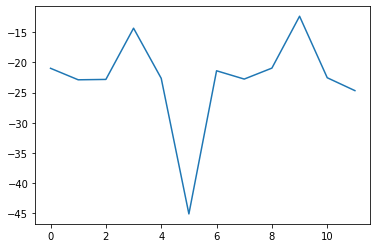

In [15]:
plt.plot(t['volumes'])
plt.show()

In [2]:
def check_volume(vol):
    threshold = [-29, -24.6, -20.2, -15.8]

    if vol <= threshold[0]:
        return 0
    elif vol <= threshold[1]:
        return 1
    elif vol <= threshold[2]:
        return 2
    elif vol <= threshold[3]:
        return 3
    else:
        return 4


def voice_py():
    
    link = "../20220401/20220401_194510_voice.wav"
    audio_bytes = wave.open(link,'rb')
    Freq = 16000
    audio_bytes = audio_bytes.readframes(14400000)

    
    # Convert wav to audio_segment
    audio_segment = AudioSegment.from_raw(
        io.BytesIO(audio_bytes),
        sample_width=2,
        frame_rate=Freq,
        channels=1
    )

    nonsilent_data = detect_nonsilent(
        audio_segment,
        min_silence_len=900,
        silence_thresh=-37,
        seek_step=1
    )

    remove_list = []
    for i in nonsilent_data:
        if ((i[1] - i[0]) < 350):
            remove_list.append(i)
    for i in remove_list:
        nonsilent_data.remove(i)


    header = audio_bytes[:70]

    user_talk_time = nonsilent_data

    audio_seg_u = []

    for i in user_talk_time:
        a = i[0] * 32 + 16000
        b = i[1] * 32 + 16000
        audio_seg_u.append(AudioSegment.from_raw(
            io.BytesIO(header + audio_bytes[a:b]),
            sample_width=2,
            frame_rate=Freq,
            channels=1
        ))

    volumes = []
    for i in range(len(audio_seg_u)):
        volumes.append(audio_seg_u[i].dBFS)

    # volume class - 0: too quiet, 1: a little quiet, 2: appropriate, 3: a little loud, 4: too loud
    volume_class = []
    for i in volumes:
        volume_class.append(check_volume(i))
    
    return user_talk_time, volumes, volume_class

voice_py()

([[0, 1168],
  [11200, 13381],
  [14787, 16678],
  [50416, 51832],
  [56023, 57422],
  [60648, 61130],
  [68572, 71179],
  [72091, 73811],
  [94438, 96617],
  [99925, 104377]],
 [-32.7270811091929,
  -23.21147024886968,
  -29.592402194137794,
  -24.895421976300227,
  -22.865492976893073,
  -42.14419939295736,
  -24.124915105786204,
  -26.25378495133036,
  -21.166506173126184,
  -22.280987883563476],
 [0, 2, 0, 1, 2, 0, 2, 1, 2, 2])

In [52]:
app = Flask(__name__)
app.config['JSON_AS_ASCII'] = False
api = Api(app)

CORS(app, resources={r'/*': {'origins': '*'}})



@api.route('/hello')  # 데코레이터 이용, '/hello' 경로에 클래스 등록
class HelloWorld(Resource):
    def get(self):  # GET 요청시 리턴 값에 해당 하는 dict를 JSON 형태로 반환
        return {"This is": "Test!"}


    
# 이 class는 EDA 결과를 저장하는 APi 이다.
@api.route('/eda')
class makeEDA(Resource):
    def post(self):
        
        f = request.files['file']
        f.save('./uploads/'+secure_filename(f.filename))

        data = pd.read_csv('./uploads/'+secure_filename(f.filename))
        
        data['time'] = [i.replace(" ", "") for i in data[' Time']]
        data['t2u'] = [time.mktime(datetime.strptime(str(data['Date'][i])+data['time'][i],'%Y%m%d%H:%M:%S').timetuple())
                     for i in range(0, len(data))]
        data = data.drop(' Time', axis=1)
        data = data.drop('Date', axis=1)
        incol = []
        for i in data['t2u']:
             incol.append(i - data['t2u'][0])
        data['idx'] = incol
        end = incol[-1]


        hmd = data[['idx','t2u',' Left_pos.x', ' Left_pos.y', ' Left_pos.z',
               ' Left_rot.x', ' Left_rot.y', ' Left_rot.z']]
        e4Eda = data[['idx','t2u',' EDA']]
        e4Bvp = data[['idx','t2u',' BVP']]
        e4Tmp = data[['idx','t2u',' TMP']]
        eyeTracker = data[['idx','t2u',' combined_x', ' combined_y', ' combined_z', ' r_bit', ' r_open',
               ' r_dir_x', ' r_dir_y', ' r_dir_z', ' r_gaze_origin_x',
               ' r_gaze_origin_y', ' r_gaze_origin_z', ' r_pupil', ' r_pupil_pos',
               ' r_pupil_pos_x', ' r_pupil_pos_y', ' r_frown', ' r_squeeze',
               ' r_widel_bit', ' l_open', ' l_dir_x', ' l_dir_y', ' l_dir_z',
               ' l_gaze_origin_x', ' l_gaze_origin_y', ' l_gaze_origin_z', ' l_pupil',
               ' l_pupil_pos', ' l_pupil_pos_x', ' l_pupil_pos_y', ' l_frown',
               ' l_squeeze', ' l_wide']]
        
        edaCon = (e4Eda[' EDA'] != ' default')
        bvpCon = ( e4Bvp[' BVP'] != ' ')
        tmpCon = (e4Tmp[' TMP'] != ' ') &  (e4Tmp[' TMP'] != ' R device_subscribe gsr O') & (e4Tmp[' TMP'] != ' R device_subscribe bvp O') & (e4Tmp[' TMP'] != ' R device_subscribe tmp O')


        e4Eda = (e4Eda[edaCon]).reset_index(drop=True)
        e4Bvp = (e4Bvp[bvpCon]).reset_index(drop=True)
        e4Tmp = (e4Tmp[tmpCon]).reset_index(drop=True)

        e4Eda['unix'] = [i[8:22] for i in e4Eda[' EDA']]
        e4Eda['data'] = [float(i[23:]) for i in e4Eda[' EDA']]
        e4Eda = e4Eda.drop(' EDA',axis=1)

        e4Bvp['unix'] = [i[8:24] for i in e4Bvp[' BVP']]
        e4Bvp['data'] = [float(i[25:]) for i in e4Bvp[' BVP']]
        e4Bvp = e4Bvp.drop(' BVP', axis=1)

        e4Tmp['unix'] = [i[16:31] for i in e4Tmp[' TMP']]
        e4Tmp['data'] = [float(i[32:]) for i in e4Tmp[' TMP']]
        e4Tmp = e4Tmp.drop(' TMP', axis=1)
        
        p_hmd = pd.DataFrame()
        p_hmd['time'] = range(0, int(end))
        for x in hmd.columns[2:]:
            result = []
            s = []
            t = 0
            for i in range(0, len(hmd)-1):
    
                if hmd['idx'][i] == hmd['idx'][i+1]:
                    t +=1
                    s.append(hmd[x][i])
                else:
                    if len(s) == 0:
                        t +=1
                        s.append(hmd['idx'][i])
                    avg = sum(s) / t
                    result.append(avg)
                    s = []
                    t = 0
            p_hmd[x] = result

        p_eye = pd.DataFrame()
        p_eye['time'] = range(0, int(end))

        for x in eyeTracker.columns[2:]:
            result = []
            s = []
            t = 0
            for i in range(0, len(eyeTracker)-1):
                if eyeTracker['idx'][i] == eyeTracker['idx'][i+1]:
                    t += 1
                    s.append(eyeTracker[x][i])
                else:
                    if len(s) == 0:
                        t += 1
                        s.append(eyeTracker['idx'][i])
                    avg = sum(s) / t
                    result.append(avg)
                    s = []
                    t = 0
            
            p_eye[x] = result
        
        e4 = [e4Bvp, e4Eda, e4Tmp]
        p_bvp = pd.DataFrame()
        p_eda = pd.DataFrame()
        p_tmp = pd.DataFrame()
        
        for n, d in enumerate(e4):
            result = []
            s = []
            t = 0
            start = d['idx'][0]
            end  =d['idx'].iloc[-1]
            for i in range(0, len(d)-1):
                if d['idx'][i] == d['idx'][i+1]:
                    t += 1
                    s.append(d['data'][i])
                else:
                    if len(s) == 0:
                        t += 1
                        s.append(d['data'][i])
                    avg = sum(s) / t
                    result.append(avg)
                    s = []
                    t = 0

            if n == 0:
                p_bvp['time'] = range(int(start), int(end))
                p_bvp['data'] = result    
            elif n == 1:
                p_tmp['time'] = range(int(start), int(end))
                p_tmp['data'] = result    
            elif n == 2:
                p_eda['time'] = range(int(start), int(end))
                p_eda['data'] = result    

    
        
        t = {
            'hmd': {
                'time': list(p_hmd['time']),
                'x' : list(p_hmd[' Left_pos.x']),
                'y' : list(p_hmd[' Left_pos.y']),
                'z' : list(p_hmd[' Left_pos.z'])
            },
            'eye': {
                'time': list(p_eye['time']),
                'rP': list(p_eye[' r_pupil']),
                'lP': list(p_eye[' l_pupil'])
            },
            'eda': {
                'time' : list(p_eda['time']),
                'data' : list(p_eda['data']),
            },
            'bvp': {
                'time' : list(p_bvp['time']),
                'data' : list(p_bvp['data']),
            },
            'tmp': {
                'time' : list(p_tmp['time']),
                'data' : list(p_tmp['data'])
            }
        }

        return t

if __name__ == '__main__':
    app.run()
    

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Dec/2021 22:31:07] "GET /voice HTTP/1.1" 404 -
127.0.0.1 - - [14/Dec/2021 22:31:08] "POST /eda HTTP/1.1" 200 -


In [18]:
data = pd.read_csv('../12_29_16_V-DAT.csv')
data['time'] = [i.replace(" ", "") for i in data[' Time']]
data['unix'] = [time.mktime(datetime.datetime.strptime(str(data['Date'][i])+data['time'][i],'%Y%m%d%H:%M:%S').timetuple())
                for i in range(0, len(data))]
data = data.drop(' Time', axis=1)
data = data.drop('Date', axis=1)
incol = []
for i in data['unix']:
    incol.append(i - data['unix'][0])
data['idx'] = incol
end = incol[-1]


hmd = data[['idx','unix',' Left_pos.x', ' Left_pos.y', ' Left_pos.z',
               ' Left_rot.x', ' Left_rot.y', ' Left_rot.z']]
e4Eda = data[['idx','unix',' EDA']]
e4Bvp = data[['idx','unix',' BVP']]
e4Tmp = data[['idx','unix',' TMP']]
eyeTracker = data[['idx','unix',' combined_x', ' combined_y', ' combined_z', ' r_bit', ' r_open',
               ' r_dir_x', ' r_dir_y', ' r_dir_z', ' r_gaze_origin_x',
               ' r_gaze_origin_y', ' r_gaze_origin_z', ' r_pupil', ' r_pupil_pos',
               ' r_pupil_pos_x', ' r_pupil_pos_y', ' r_frown', ' r_squeeze',
               ' r_widel_bit', ' l_open', ' l_dir_x', ' l_dir_y', ' l_dir_z',
               ' l_gaze_origin_x', ' l_gaze_origin_y', ' l_gaze_origin_z', ' l_pupil',
               ' l_pupil_pos', ' l_pupil_pos_x', ' l_pupil_pos_y', ' l_frown',
               ' l_squeeze', ' l_wide']]
        
edaCon = (e4Eda[' EDA'] != ' default')
bvpCon = ( e4Bvp[' BVP'] != ' ')
tmpCon = (e4Tmp[' TMP'] != ' ') &  (e4Tmp[' TMP'] != ' R device_subscribe gsr O') & (e4Tmp[' TMP'] != ' R device_subscribe bvp O') & (e4Tmp[' TMP'] != ' R device_subscribe tmp O')


e4Eda = (e4Eda[edaCon]).reset_index(drop=True)
e4Bvp = (e4Bvp[bvpCon]).reset_index(drop=True)
e4Tmp = (e4Tmp[tmpCon]).reset_index(drop=True)

e4Eda['unix'] = [i[8:22] for i in e4Eda[' EDA']]
e4Eda['data'] = [float(i[23:]) for i in e4Eda[' EDA']]
e4Eda = e4Eda.drop(' EDA',axis=1)

e4Bvp['unix'] = [i[8:24] for i in e4Bvp[' BVP']]
e4Bvp['data'] = [float(i[25:]) for i in e4Bvp[' BVP']]
e4Bvp = e4Bvp.drop(' BVP', axis=1)

e4Tmp['unix'] = [i[16:31] for i in e4Tmp[' TMP']]
e4Tmp['data'] = [float(i[32:]) for i in e4Tmp[' TMP']]
e4Tmp = e4Tmp.drop(' TMP', axis=1)
        
p_hmd = pd.DataFrame()
p_hmd['time'] = range(0, int(end))


In [17]:
e4Bvp

,idx,unix,data
0,2.0,1639452560.42384,-23.44609
1,2.0,1639452560.42384,-23.44609
2,2.0,1639452560.42384,-23.44609
3,2.0,1639452560.42384,-23.44609
4,2.0,1639452560.42384,-23.44609
...,...,...,...
3863,79.0,1639452637.59929,41.34004
3864,79.0,1639452637.59929,41.34004
3865,79.0,1639452637.77117,23.35320
3866,79.0,1639452637.77117,23.35320
